# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud. There are over 300K entries, with a small subset representing fraud. 

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) of dataset. Modified slightly by DataCamp, from where I downloaded it.

In [128]:
# Import relevant libraries for data handling + filing
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Statistics and machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, make_scorer, fbeta_score

from xgboost import XGBClassifier

SEED = 21

# Set seeds globally for reproducibility
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [89]:
# Load data
ccf = pd.read_csv('credit_card_fraud.csv',parse_dates=['trans_date_trans_time'])
ccf.head(100)

ccf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  339607 non-null  datetime64[ns]
 1   merchant               339607 non-null  object        
 2   category               339607 non-null  object        
 3   amt                    339607 non-null  float64       
 4   city                   339607 non-null  object        
 5   state                  339607 non-null  object        
 6   lat                    339607 non-null  float64       
 7   long                   339607 non-null  float64       
 8   city_pop               339607 non-null  int64         
 9   job                    339607 non-null  object        
 10  dob                    339607 non-null  object        
 11  trans_num              339607 non-null  object        
 12  merch_lat              339607 non-null  floa

## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

There does not seem to be any evidence of missing data points. However, it is possible that the missing values are present and labeled oddly. Let's do a deeper dive of the elements making up the dataset. 

# Data Exploration

'Fraud comprises  0.5% of all transactions'

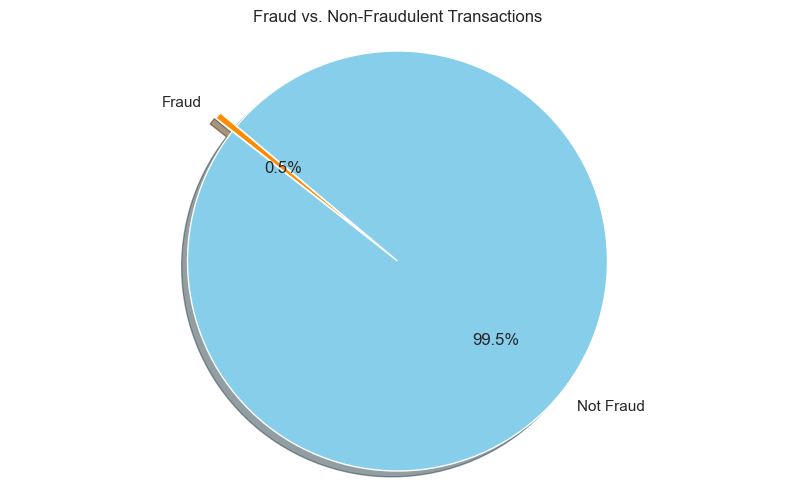

In [90]:
# The data set is massive and fraud should be relatively sparse. In order to get a better sense of what the data look like without imposing the computational load of interacting with 300K+ data points, we will sample the non-fraudulent data set such that so we have the same number of data points as the fraudulent transactions.

# Note that fraud makes up a tiny percentage of the overall data set
percent_fraud = np.round(ccf['is_fraud'].mean()*100,2)
display(f"Fraud comprises {percent_fraud: .1f}% of all transactions")
# Split the fraud and non-fraud datsets
ccf_fraud = ccf[ccf['is_fraud']==1]
ccf_true = ccf[ccf['is_fraud']==0]
ccf_true_smallsample = ccf_true.sample(len(ccf_fraud),random_state=SEED)
# Make the histogram
bins = np.arange(0,2000,20)
fig, ax = plt.subplots(1,1,figsize=(10,6))

# Use a colorblind-friendly palette
colors = [mcolors.cnames['darkorange'], mcolors.cnames['skyblue']]  # Blue, Orange (colorblind-friendly)

nonfraudcolor = colors[0]
fraudcolor = colors[1]
# # Plotting non-fraudulent transactions
# ccf_true_smallsample.hist('amt',
#                           bins=bins,
#                           ax=ax,
#                           alpha=.8,
#                           color=nonfraudcolor,
#                           density=True,
#                           grid=False
#                           )
# ax.set_title('Transaction Amount Distribution')  # Set title for the histogram
# ax.set_xlabel('Amount ($)')  # Set X-label for the histogram
# ax.set_ylabel('Density')  # Set Y-label for the histogram
# ax.legend(["Not Fraud"])
# # Plotting fraudulent transactions
# ccf_fraud.hist('amt',
#                bins=bins,
#                ax=ax,
#                alpha=.8,
#                color=fraudcolor,
#                density=True,
#                grid=False
#                )
# 
# ax.legend(["Not Fraud","Fraud"])


# Pie chart of fraud
fraud_count = ccf['is_fraud'].sum()
non_fraud_count = len(ccf) - fraud_count

# Data to plot
labels = 'Fraud', 'Not Fraud'
sizes = [fraud_count, non_fraud_count]
# colors = ['darkorange', 'skyblue']
explode = (0.1, 0)  # explode the first slice (fraud)
# Plot pie
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Fraud vs. Non-Fraudulent Transactions')
plt.show()

In [80]:
# # Smaller sample of data for plotting and analysis
# # Stratified sampling to look at representative subset of data.
# num_samples = 40000
# 
# fraud_samples = int(num_samples * percent_fraud/100)
# nonfraud_samples = num_samples - fraud_samples
# # Separate fraud and non-fraud
# fraud_sample = ccf[ccf['is_fraud']==1].sample(n=fraud_samples,random_state=SEED)
# nonfraud_sample = ccf[ccf['is_fraud']==0].sample(n=nonfraud_samples,random_state=SEED)
# # Concatenate fraud and non-fraud samples
# ccf_sample = pd.concat([fraud_sample,nonfraud_sample])

# Feature Engineering

## Relevant Dates and Times (e.g. Age, transaction day, etc)

               mean  median  min  max
is_fraud                             
0         47.314296    45.0   17   93
1         50.270483    50.0   19   91


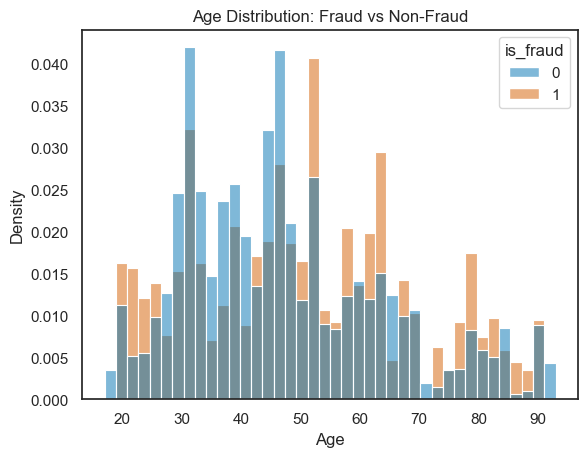

In [91]:
# Convert 'trans_date_trans_time' and 'dob' to datetime

ccf['trans_date_trans_time'] = pd.to_datetime(ccf['trans_date_trans_time'])
ccf['dob'] = pd.to_datetime(ccf['dob'])

# Extract date and time features
ccf['trans_hour'] = ccf['trans_date_trans_time'].dt.hour
ccf['trans_day_of_week'] = ccf['trans_date_trans_time'].dt.dayofweek

# Calcualte age in years. Are younger or older folks more likely to be victims?
ccf['Age'] = (ccf['trans_date_trans_time']-ccf['dob']).dt.days // 365

# Mean / median age by fraud vs non-fraud
print(ccf.groupby('is_fraud')['Age'].agg(['mean','median','min','max']))

sns.histplot(data=ccf,
             x='Age',
             hue='is_fraud',
             bins=40,
             stat='density',
             common_norm=False,
             palette=["#0072B2", "#D55E00"])
plt.title("Age Distribution: Fraud vs Non-Fraud")
plt.show()

                mean   median   min       max
is_fraud                                     
0          68.217523   46.250  1.00  28948.90
1         518.065460  356.435  1.78   1371.81


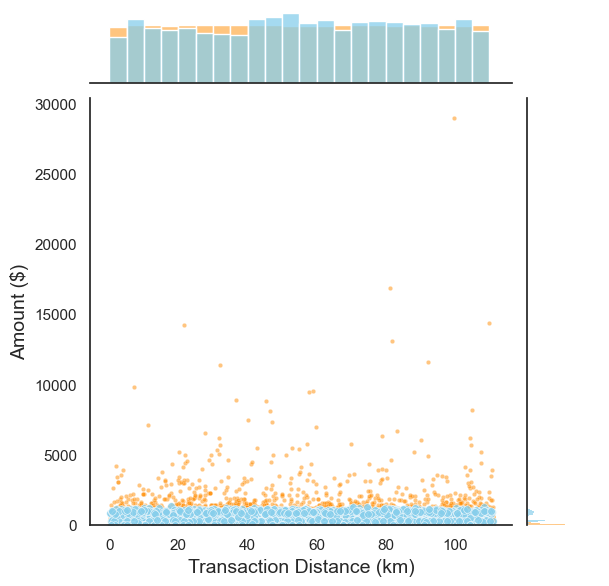

In [92]:
# 40,075 km / 360 degrees = 111 km per degree of latitude
ccf['lat_diff'] = (ccf['lat'] - ccf['merch_lat']) * 111
# Longitude – conversion to radians and determine the distance based on where you are on earth
# Note that at the equator, 1 degree = 111 km, same as latitude. However, as you move towards the poles this gets shorter. This latitude difference can be adjusted for in the longitude calculation 
ccf['lon_diff'] = (ccf['long'] - ccf['merch_long']) * np.deg2rad(1) * 111 * np.cos(np.deg2rad(ccf['merch_lat']))
# Calculate hypotenuse
ccf['transaction_distance'] = np.sqrt(ccf['lat_diff'] ** 2 + ccf['lon_diff'] ** 2)



sns.set_context('notebook')
sns.set_style('white')
g = sns.JointGrid(data=ccf,x='transaction_distance',y='amt',hue='is_fraud',)

# Plot non-fraudulent transactions first with smaller points and lower alpha
sns.scatterplot(data=ccf[ccf['is_fraud'] == 0], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=nonfraudcolor, alpha=0.5, s=10)

# Overlay with fraudulent transactions with larger points and higher alpha for better visibility
sns.scatterplot(data=ccf[ccf['is_fraud'] == 1], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=fraudcolor, alpha=0.8, s=30)

dist_binsize = 5 # in km
# Plot histograms with density on the margins for non-fraudulent transactions
sns.histplot(data=ccf[ccf['is_fraud'] == 0], 
             x='transaction_distance', 
             ax=g.ax_marg_x,
             stat='density', 
             color=nonfraudcolor, alpha=0.5,
             bins = np.arange(0,ccf[ccf['is_fraud'] == 0]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf[ccf['is_fraud'] == 0], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=nonfraudcolor, alpha=0.5, 
             bins = np.arange(0,ccf[ccf['is_fraud'] == 0]['amt'].max(),50))

# Overlay with histograms with density on the margins for fraudulent transactions
sns.histplot(data=ccf[ccf['is_fraud'] == 1], x='transaction_distance',
             ax=g.ax_marg_x,
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf[ccf['is_fraud'] == 1]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf[ccf['is_fraud'] == 1], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf[ccf['is_fraud'] == 1]['amt'].max(),50))
g.set_axis_labels(ylabel='Amount ($)',xlabel='Transaction Distance (km)',fontsize = 14)
g.ax_joint.set_ylim(0,)

# Mean / median amount by fraud vs non-fraud: dollar amount will almost certainly provide valuable information for ML models
print(ccf.groupby('is_fraud')['amt'].agg(['mean','median','min','max']))


There seems to be no simple relationship between amount and the distance between merchant and transaction source. This is not surprising in the new global order with online shopping. Casting a wider net, next we will try some machine learning approaches which will help us determine which features of the dataset have the greatest potential for detecting fraudulent transactions.

## Transaction Time
Fraudsters will often make several transactions at once. Is there a timing component that might help?

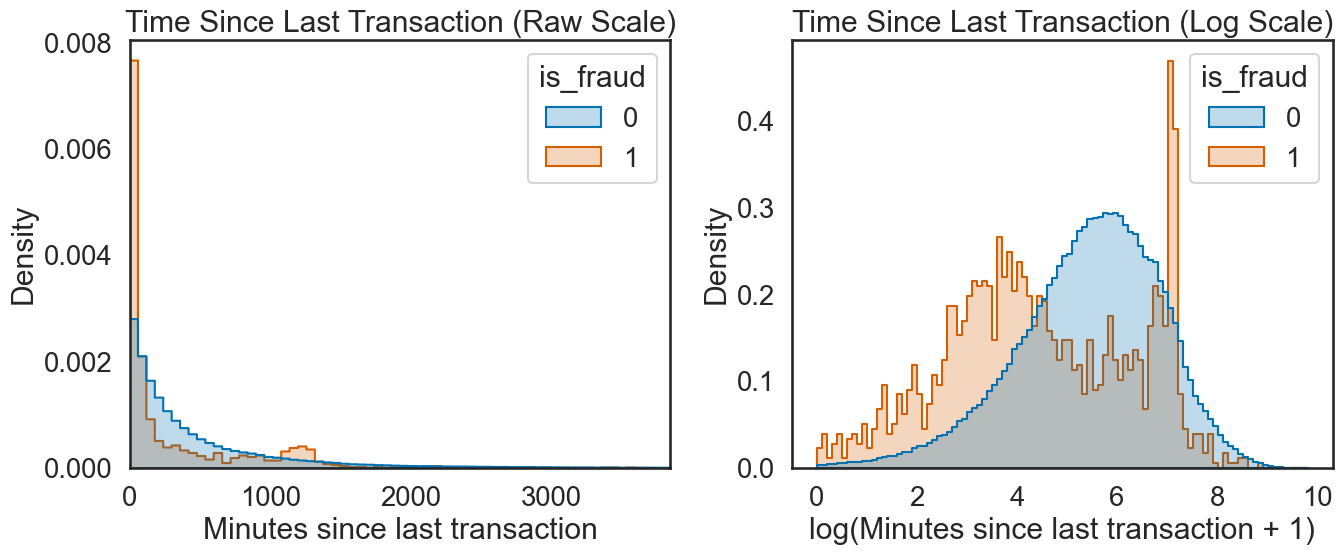

In [93]:
# We don't have a way to identify each credit card number, but the combination of job, dob, city, and state will hopefully help us narrow it down. Obviously, this isn't 100% accurate, but it will get us closer to the truth.

# %% Transaction Time - ensure datetime format
ccf['trans_date_trans_time'] = pd.to_datetime(ccf['trans_date_trans_time'])

# Create a pseudo-customer ID by combining job, dob, state, city
ccf['dob'] = pd.to_datetime(ccf['dob'])
ccf['customer_pseudoid'] = (
        ccf['job'].astype(str) + "_" +
        ccf['dob'].astype(str) + "_" +
        ccf['state'].astype(str) + "_" +
        ccf['city'].astype(str)
)

# Sort by this pseudo-ID and transaction time
ccf = ccf.sort_values(by=['customer_pseudoid', 'trans_date_trans_time'])

# Compute time since last transaction per pseudo-customer
ccf['time_since_last_transaction'] = ccf.groupby('customer_pseudoid')['trans_date_trans_time'].diff()

# Convert timedelta to minutes
ccf['time_since_last_transaction'] = (
        ccf['time_since_last_transaction'].dt.total_seconds()/60)

# Fill NaN (first transaction per customer) with -1
ccf['time_since_last_transaction'] = ccf['time_since_last_transaction'].fillna(-1)

# Plot transaction time data
plot_df = ccf.copy()
plot_df['time_since_last_transaction'] = plot_df['time_since_last_transaction'].replace(-1, np.nan)

# Log-transform (+1 to avoid log(0))
plot_df['log_time_since_last_transaction'] = np.log1p(plot_df['time_since_last_transaction'])

# Set up color palette
colors = ["#0072B2", "#D55E00"]  # Blue for non-fraud, Orange for fraud

# Set context
sns.set_context('talk',font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw scale
sns.histplot(data=plot_df,
             x='time_since_last_transaction',
             hue='is_fraud',
             binwidth=60, # 1 hour
             stat='density',
             element='step',
             common_norm=False,
             palette=colors,
             ax=axes[0])

upper_limit = np.percentile(plot_df['time_since_last_transaction'].dropna(), 99)
axes[0].set_xlim(0, upper_limit)
axes[0].set_title("Time Since Last Transaction (Raw Scale)")
axes[0].set_xlabel("Minutes since last transaction")

# Log scale
sns.histplot(data=plot_df,
             x='log_time_since_last_transaction',
             hue='is_fraud',
             binwidth=0.1,
             stat='density',
             element='step',
             common_norm=False,
             palette=colors,
             ax=axes[1])
axes[1].set_title("Time Since Last Transaction (Log Scale)")
axes[1].set_xlabel("log(Minutes since last transaction + 1)")

plt.tight_layout()
plt.show()


In [101]:
plot_df_fraud = plot_df[plot_df['is_fraud']==1]
print(plot_df.shape)
# Drop NaNs just in case
log_vals = plot_df_fraud['log_time_since_last_transaction'].dropna()
# Create histogram in log space (same binwidth you used in plotting)
counts, bin_edges = np.histogram(log_vals, bins=np.arange(log_vals.min(), log_vals.max(), 0.1))

# Index of the bin with the max count (mode bin)
mode_idx = np.argmax(counts)

# Bin edges give left/right boundaries, so take the midpoint
mode_log_val = (bin_edges[mode_idx] + bin_edges[mode_idx+1]) / 2

# Convert back to minutes using expm1 (inverse of log1p)
mode_minutes = np.expm1(mode_log_val)
mode_hours = mode_minutes//60
remainder_mins = mode_minutes % 60


print(f"Mode in log space: {mode_log_val:.2f}")
print(f"Corresponding time since last transaction: {mode_hours:.0f} hours, {remainder_mins:.0f} mins")

(339607, 24)
Mode in log space: 7.10
Corresponding time since last transaction: 20 hours, 10 mins


Visually, this seems to be a useful variable. Fraudsters do indeed seem to cluster their purchasing activity a bit more than non-fraud as evident by the raw and log distributions. The log distribution shows a leftward shift in fraudulent transactions, indicating that those transactions tend to happen in short-duration groupings. There also seems to be a spike in activity just as we are reaching 24 hours since last transaction. ML models should be able to use this type of information to separate fraud vs. not.

# Data Preprocessing & One-Hot Encoding

In [139]:
# Select categorical and numerical columns for encoding and scaling
categorical_cols = ['category']  # Using simple categories for one-hot encoding
drop_cols = ['merchant', 'city', 'job']  # drop columns with too many unique values
numerical_cols = ['amt', 'city_pop', 'lat_diff', 'lon_diff', 'transaction_distance', 'trans_hour', 'trans_day_of_week', 'Age']

# We will initially drop columns with high degrees of freedom for simplicity
ccf = ccf.drop(columns=drop_cols, errors='ignore')

# Define preprocessor - Scale numerical columns, One Hot Encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # numericals
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # categoricals
    ])
# Define F2 scorer (recall preferred, precision considered)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Recall Scorer (recall only)
recall_scorer = make_scorer(recall_score)

# Define stratified folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Separate features and target variable
X = ccf.drop(columns=['is_fraud', 'trans_num', 'trans_date_trans_time'])  # Dropping unique identifier and original datetime
y = ccf['is_fraud']

# 
# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Apply preprocessing
# X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

# # Check the shape of the preprocessed data
# display(X_train_preprocessed.shape), display(X_test_preprocessed.shape)
# 
# # Get feature names back
# ohe = preprocessor.named_transformers_['cat']
# ohe_features = ohe.get_feature_names_out(categorical_cols)
# # 
# # # Combine with numeric feature names
# feature_names = numerical_cols + list(ohe_features)
# 
# print(feature_names)


# Random Forest and XGBoost Classifier
Random Forest is a good choice for this type of problem for a couple of reasons. 

We have imbalanced data due to the relative rarity of fraud. RF can train on rare events for a variety of reasons including its use of bootstrap sampling (such that you can have certain trees with a higher-than-normal proportion of fraud) and the complexity of individual decision trees combined with the "democratic" nature of majority voting/averaging (akin to a concept of spike-triggered averaging in my field of neuroscience). Additionally, RF can capture complex non-linear relationships, partly due to the complexity inherent in many decision trees. Indeed, RF can grow without much restriction. This makes it a good model for this type of analysis, but not when real-time predictions are required, where it can be a bit slow. 

XGBoost takes the idea of the parallel Random Forests/majority rule concept and turns it into a series design. Trees in XGBoost generally are shallower and learn from the mistakes of their ancestors. XGBoost models often win Kaggle competitions. For the sake of simplicity, we can skip the initial RF run, which is rather unimpressive. Instead, we will focus on the two-stage model building approach laid out in previous versions of this code. 

In [140]:
# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(
#     n_estimators=500, 
#     class_weight='balanced', # upweight rare class
#     max_depth=None,
#     min_samples_leaf=2,
#     random_state=21)
# 
# # Train the model
# rf_classifier.fit(X_train_preprocessed, y_train)
# 
# # Predict on the testing set
# y_pred = rf_classifier.predict(X_test_preprocessed)
# y_pred_proba = rf_classifier.predict_proba(X_test_preprocessed)[:, 1]
# 
# # Display the DataFrame
# cm = confusion_matrix(y_test,y_pred)
# TP = cm[1,1]
# FP = cm[0,1]
# TN = cm[0,0]
# FN = cm[1,0]
# print(cm)
# report = classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"])
# print(report)


<b> A Reminder on Terminology: </b>
* <b>Recall:</b> The true positive rate vs. (i.e., of the actually fraudulent cases, what proportion did you detect?)
* <b>Precision:</b> True positive vs. all positive prediction(i.e., of the cases identified as fraudulent, how many actually were?)

Under usual circumstances, having > 0.99 weighted avg across multiple metrics would be a resounding success. However, this is data on fraud; we'd rather incorrectly flag some non-fraudulent transactions as fraud than miss actually fraudulent transactions. Given the class imbalance, our weighted metrics are way off. Looks like we're only detecting ~2/3 cases here, but missing the other 1/3. The fact that we can detect non-fraudulent cases is not a great success. We'd rather miss some of those and capture every single one of the fraudualent cases (i.e. high recall, low precision). 

In our context, we want to maximize recall, even if it comes at the expense of precision, for the fraud group (rare class). The weighted averages shown in the "metrics" are extremely leading and shown for demonstration purposes only.  

To address this, we will attempt a gradient boosting (XGBoost) approach, which is basically the "series" circut version of RF. That is, each decision tree is developed based on the previous trees and can thus learn from the errors of its ancestors, so to speak.

## XGBoost
In our first pass model, if all we care about is fraud, we want to maximize recall. This is similar to a principle in medicine: pick a sensitive test first (like PSA for prostate cancer), follow up with a more specific test based on individual factors (like a biopsy). 

In reality, any case of fraud should get flagged for follow-up. Even with 300,000+ transactions, we will identify between 1500-2000 cases of actual fraud (~0.5%). Maximizing the first pass test recall gives us almost all of the fraud (fraud is rarely missed), but we also get a lot false positives (non-fraud transactions that get flagged). 

Another nice feature: XGBoost is relatively fast, especially compared to RF!

In [147]:
# Initialize the model with scale_pos_weight to handle imbalance
# Adjust scale_pos_weight based on the ratio of negative to positive instances; this helps with the detection of rare events (e.g. fraud)
fraud_yes = (ccf['is_fraud']==1).sum()
fraud_not = (ccf['is_fraud']==0).sum()
ratio_neg_pos = fraud_not / fraud_yes

# Instantiate model
xgb = XGBClassifier(
    random_state=SEED,
    scale_pos_weight=ratio_neg_pos,
    eval_metric="logloss"
)

# Define the primary data pipline: preprocess, then xgb
pipeline_onemodel = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])

# Set parameter search space
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5],
    "model__gamma": [0, 1, 5]
}
# Set up randomized search on pipeline
search = RandomizedSearchCV(
    estimator=pipeline_onemodel,
    param_distributions=param_grid, # defined immediately prior
    n_iter=25,                 # number of random samples from the grid
    scoring=recall_scorer,         # optimize recall across folds
    cv=skf,                    # Stratified 5-fold CV
    verbose=2,
    n_jobs=-1,
    random_state=SEED
)

search.fit(X, y)

print("Best Parameters:")
print(search.best_params_)

print(f"Best Recall : {search.best_score_:.3f}")

best_pipeline = search.best_estimator_

# Refit automatically on all data by default
best_model = best_pipeline.named_steps['model']

print("Best XGBoost params:", best_model.get_params())

cv_results_final = cross_validate(
    best_pipeline,
    X, y,
    cv=skf,
    scoring={'recall': 'recall', 'precision': 'precision', 'f2': f2_scorer},
    n_jobs=-1
)

summary = pd.DataFrame(cv_results_final).agg(['mean', 'std'])
print(summary)
# generate predictions to use for data evaluation 
y_pred = best_pipeline.predict(X)
y_true = y
y_pred_proba = best_pipeline.predict_proba(X)[:, 1]
print(classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))

cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:\n", cm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:
{'model__subsample': 1.0, 'model__n_estimators': 200, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 0.8}
Best Recall : 0.961
Best XGBoost params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'n

## XGB Results Interpretation
Results from the cross-validated and randomized search pipeline indicate that the model achieves very high recall (0.97) for the fraud class, meaning it successfully identifies 97% of all fraudulent transactions in the dataset. However, precision remains relatively low (0.17), implying that only about one in six flagged transactions is actually fraudulent. This trade-off is intentional given the optimization objective—maximizing recall to minimize missed fraud. 

Operationally, these results suggest the model is highly sensitive but not yet selective—it catches nearly all fraudulent activity, but at the cost of additional manual review or secondary screening of flagged transactions. Based on our previous calculations, we know that fraudulent transactions are roughly $500 in loss on average, the current configuration would still result in an estimated $25,000 of undetected fraud, but prevent a far larger portion of potential loss.

In summary, the model effectively functions as a <i>first-stage detector</i>: it prioritizes safety (few missed frauds) over efficiency (false alarms). The parallels to medical screenings should be clear. In continuing with the analogy to medicine, we will next focus on improving precision by adjusting the pipeline to incorporate a secondary model that is optimized for precision.


# False Positives EDA

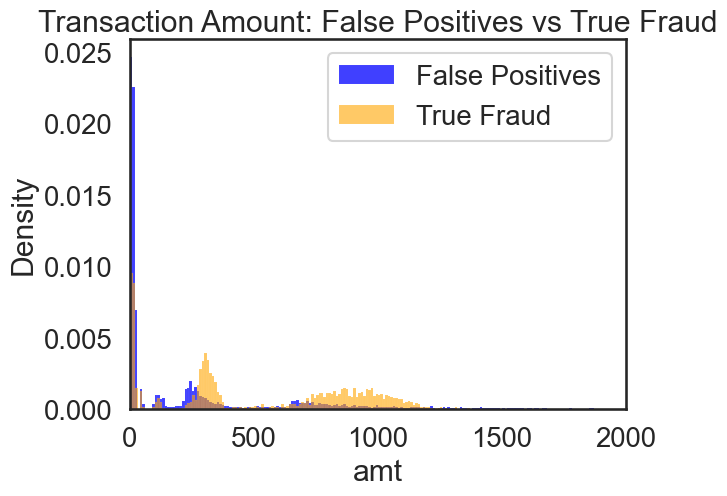

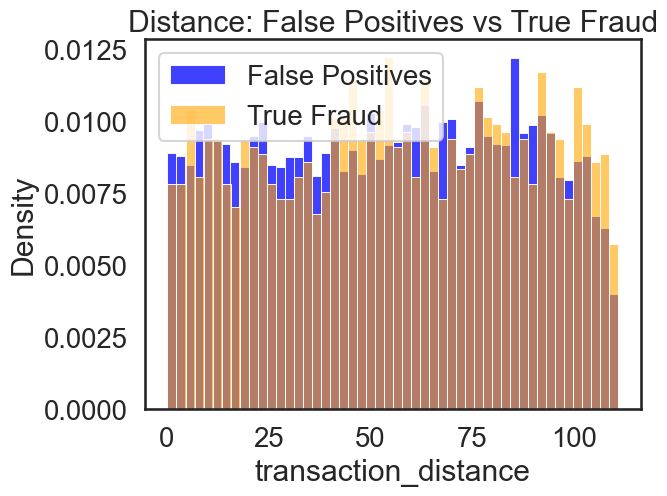

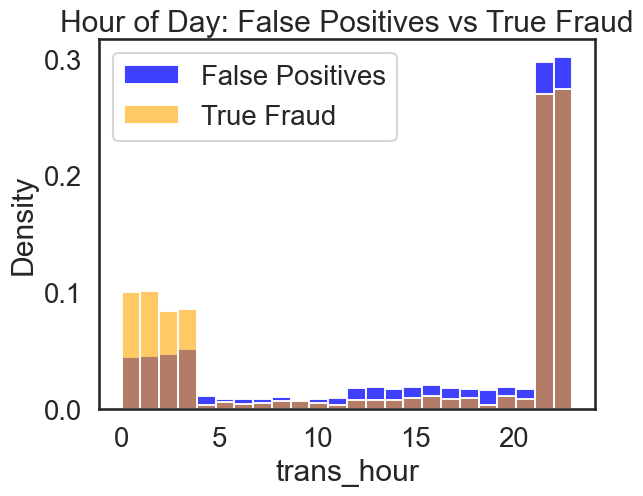

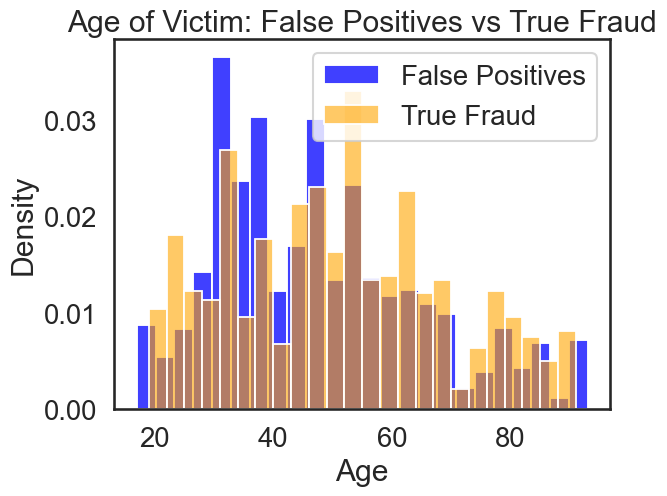

In [149]:
# First, identify the False Positive and return to EDA and feature engineering

# Get indices of FP cases
# Identify indices
false_pos_idx = (y == 0) & (y_pred == 1)
true_pos_idx = (y == 1) & (y_pred == 1)

# Extract the original (unprocessed) rows for EDA
false_pos = X.loc[false_pos_idx].copy()
true_pos  = X.loc[true_pos_idx].copy()

# Add model confidence score
false_pos['score'] = y_pred_proba[false_pos_idx]
true_pos['score']  = y_pred_proba[true_pos_idx]

# Transaction Amount
sns.histplot(data=false_pos, x='amt', color='blue', label='False Positives', stat='density', binwidth=10)
sns.histplot(data=true_pos, x='amt', color='orange', label='True Fraud', stat='density', binwidth=10, alpha=0.6)
plt.xlim(0,2000)
plt.legend()
plt.title("Transaction Amount: False Positives vs True Fraud")
plt.show()

# Transaction Distance
sns.histplot(data=false_pos, x='transaction_distance', color='blue', label='False Positives', stat='density', bins=50)
sns.histplot(data=true_pos, x='transaction_distance', color='orange', label='True Fraud', stat='density', bins=50, alpha=0.6)
plt.legend()
plt.title("Distance: False Positives vs True Fraud")
plt.show()

# Hour of the Day
sns.histplot(data=false_pos, x='trans_hour', color='blue', label='False Positives', stat='density', bins=24)
sns.histplot(data=true_pos, x='trans_hour', color='orange', label='True Fraud', stat='density', bins=24, alpha=0.6)
plt.legend()
plt.title("Hour of Day: False Positives vs True Fraud")
plt.show()

# Age of the victim
sns.histplot(data=false_pos, x='Age', color='blue', label='False Positives', stat='density', bins=24)
sns.histplot(data=true_pos, x='Age', color='orange', label='True Fraud', stat='density', bins=24, alpha=0.6)
plt.legend()
plt.title("Age of Victim: False Positives vs True Fraud")
plt.show()


# Re-Engineer Features and Hyperparameter Tuning

As is evident in the charts above, each of these variables may provide additional information. We probably need to try to account for subject-level differences. Again, this is similar to the medical context (do the more invasive test after the initial screening). After adding features, we will need to re-process our data.

## Add New Features - Customer Specific Spending Patterns

In [113]:
# Compute per-customer mean transaction amount
ccf['mean_amt_customer'] = ccf.groupby('customer_pseudoid')['amt'].transform('mean')

# Ratio: transaction amount relative to customer mean
ccf['amt_ratio'] = ccf['amt'] / (ccf['mean_amt_customer'] + 1)  # +1 to avoid division by 0

# Generate z scores based on the mean and std for each customer
ccf['std_amt_customer'] = ccf.groupby('customer_pseudoid')['amt'].transform('std')
ccf['amt_zscore'] = (ccf['amt'] - ccf['mean_amt_customer']) / (ccf['std_amt_customer'] + 1e-6)

# This can be used with standard techniques to check amount for each customer
# |amt_zscore| > 3 reflects the 99th percentile transactions.
ccf['flag_check_customer'] = (ccf['amt_zscore'] > 3).astype(int) 

ccf[['customer_pseudoid','mean_amt_customer','amt_ratio','amt_zscore']]

,customer_pseudoid,mean_amt_customer,amt_ratio,amt_zscore
110662,"Accountant, chartered_1941-09-30_CA_Glendale",485.706364,0.655159,-0.434406
110864,"Accountant, chartered_1941-09-30_CA_Glendale",485.706364,0.622511,-0.475780
110974,"Accountant, chartered_1941-09-30_CA_Glendale",485.706364,1.905995,1.150752
110987,"Accountant, chartered_1941-09-30_CA_Glendale",485.706364,2.059332,1.345072
110991,"Accountant, chartered_1941-09-30_CA_Glendale",485.706364,0.016108,-1.244261
...,...,...,...,...
337978,Wellsite geologist_1966-05-22_CA_Corona,65.456471,0.933694,-0.031886
338076,Wellsite geologist_1966-05-22_CA_Corona,65.456471,3.109554,1.321622
338468,Wellsite geologist_1966-05-22_CA_Corona,65.456471,0.686464,-0.185676
339325,Wellsite geologist_1966-05-22_CA_Corona,65.456471,0.791195,-0.120528


## Define Columns and Preprocess Anew

In [117]:
categorical_cols = ['category']  # Using simple categories for one-hot encoding
drop_cols = ['merchant', 'city', 'job', 'dob']  # drop columns with too many unique values
numerical_cols = [
    'amt', 'city_pop', 'lat_diff', 'lon_diff', 'transaction_distance',
    'trans_hour', 'trans_day_of_week', 'Age',
    'amt_ratio', 'amt_zscore','flag_check_customer',
]

# We will initially drop columns with high degrees of freedom for simplicity
ccf = ccf.drop(columns=drop_cols, errors="ignore")

# Separate features and target variable. Dropping unique identifier and 'leaky' features
X = ccf.drop(columns=['is_fraud', 'trans_num', 'trans_date_trans_time'])  
y = ccf['is_fraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Check the shape of the preprocessed data
display(X_train_preprocessed.shape), display(X_test_preprocessed.shape)
print(X.columns)

# Define F2 scorer (favor recall more than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)
# Define recall scorer (favor recall)
recall_scorer = make_scorer(recall_score)

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 1, 5]
}

xgb = XGBClassifier(
    scale_pos_weight=ratio_neg_pos,
    random_state=SEED,
    eval_metric="logloss"
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring=recall_scorer,  # optimize for recall-heavy F2
    cv=3,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train_preprocessed, y_train)

best_params = search.best_params_
print("Best params:", best_params)
print("Best F2 score:", search.best_score_)

(271685, 22)

(67922, 22)

Index(['category', 'amt', 'state', 'lat', 'long', 'city_pop', 'merch_lat',
       'merch_long', 'trans_hour', 'trans_day_of_week', 'Age', 'lat_diff',
       'lon_diff', 'transaction_distance', 'customer_pseudoid',
       'time_since_last_transaction', 'mean_amt_customer', 'amt_ratio',
       'std_amt_customer', 'amt_zscore', 'flag_check_customer'],
      dtype='object')
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best F2 score: 0.8180731662479076


## Implementation of Grid Search Into New RF with XGB

In [119]:
# Once more unto the breach... XGBoost Again!
# imbalance ratio was previous calculated but just to be safe:
ratio_neg_pos = (ccf['is_fraud'] == 0).sum() / (ccf['is_fraud'] == 1).sum()

# Train model
xgb_model = XGBClassifier(
    **best_params, # unpack parameters from the randomized search CV above
    scale_pos_weight=ratio_neg_pos,
    random_state=SEED,
)

xgb_model.fit(X_train_preprocessed, y_train)

thresholds = np.arange(0.01, 0.51, 0.01)

results = []

for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    results.append((t, rec, prec))

# Put into a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Threshold", "Recall", "Precision"])

# Show all thresholds where recall >= target
target_recall = 0.95
print(results_df[results_df["Recall"] >= target_recall])

# Or find the *lowest* threshold that achieves your target recall
min_recall_row = results_df[results_df["Recall"] >= target_recall].iloc[0]
print(min_recall_row)
print(f"Best threshold for Recall >= {target_recall}: {min_recall_row.Threshold:.2f} "
      f"(Recall={min_recall_row.Recall:.3f}, Precision={min_recall_row.Precision:.3f})")
y_pred = (y_pred_proba >= min_recall_row.Threshold).astype(int)

# Evaluate
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))


   Threshold    Recall  Precision
0       0.01  0.977528   0.131619
1       0.02  0.971910   0.178167
2       0.03  0.969101   0.214153
3       0.04  0.960674   0.240676
Threshold    0.010000
Recall       0.977528
Precision    0.131619
Name: 0, dtype: float64
Best threshold for Recall >= 0.95: 0.01 (Recall=0.978, Precision=0.132)
Confusion matrix:
 [[65270  2296]
 [    8   348]]
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98     67566
       Fraud       0.13      0.98      0.23       356

    accuracy                           0.97     67922
   macro avg       0.57      0.97      0.61     67922
weighted avg       1.00      0.97      0.98     67922


<b>Note:</b> There was no improvement after optimizing XGBoost parameters. However, credit card transaction data can be a quickly evolving dataset in the real world. Our model should be able to account for differences in patterns that appear in the future. Despite the potential time/computational cost, it is likely worth keeping the randomized search.

## Stage 1/Stage 2 Pipeline

In [120]:
# Stage 1: already done with XGB
y_pred_stage1 = (y_pred_proba >= min_recall_row.Threshold).astype(int)

# Subset: only keep transactions flagged as fraud by stage 1
stage1_candidates = X_test[y_pred_stage1 == 1]
stage1_labels = y_test[y_pred_stage1 == 1]

print("Stage 1 candidates:", stage1_candidates.shape)

# apply preprocessing again to match model input -- errors without this
stage1_candidates_preprocessed = preprocessor.transform(stage1_candidates)

Stage 1 candidates: (2644, 21)
Reminder of Stage 1 Results:

Confusion matrix:
 [[65270  2296]
 [    8   348]]
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98     67566
       Fraud       0.13      0.98      0.23       356

    accuracy                           0.97     67922
   macro avg       0.57      0.97      0.61     67922
weighted avg       1.00      0.97      0.98     67922


### Stage 2 Model Optimization
We will attempt to improve precision while setting a high floor for recall.

In [126]:
# Randomized search over a grid to find best parameters for RF
# first, we need a custom scorer because we want to set a hard threshold for recall and the built-ins don't let you do that. basically we'll score things that have a recall less than min_recall all as 0.
def recall_thresh_scorer(y_true, y_pred, min_recall=0.90):
    """
    Custom scorer: precision if recall >= min_recall, else 0.
    """
    recall = recall_score(y_true, y_pred, zero_division=0)
    if recall < min_recall:
        return 0.0
    return precision_score(y_true, y_pred, zero_division=0)

custom_scorer = make_scorer(recall_thresh_scorer, greater_is_better=True)

# Define and tune RF paramaeters
rf_param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 8, 12, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", "balanced_subsample"]
}
rf_base = RandomForestClassifier(random_state=SEED)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=25,
    scoring=custom_scorer,   
    cv=4,
    n_jobs=-1,
    verbose=2,
)
rf_search.fit(stage1_candidates_preprocessed, stage1_labels)

print("Best parameters:", rf_search.best_params_)

# feed best parameters into stage 2 model
best_rf = rf_search.best_estimator_ 
best_rf.fit(stage1_candidates_preprocessed, stage1_labels)

# test out stage 2 model on stage 1 output.
stage2_pred = best_rf.predict(stage1_candidates_preprocessed)

y_pred_stage2 = np.zeros_like(y_pred_stage1)
y_pred_stage2[y_pred_stage1 == 1] = stage2_pred

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}


In [125]:
# Print Model Results
# Stage 1 Results
print('Reminder of Stage 1 Results:\n')
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

# Stage 2 Results
print("\nStage 2 Report (on Stage 1 candidates):")
print(classification_report(stage1_labels, stage2_pred, target_names=["Not Fraud", "Fraud"]))

# Overall Pipeline Results
print("\nPipeline Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stage2))

print("\nPipeline Report:")
print(classification_report(y_test, y_pred_stage2, target_names=["Not Fraud", "Fraud"]))

Reminder of Stage 1 Results:

Confusion matrix:
 [[65270  2296]
 [    8   348]]
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98     67566
       Fraud       0.13      0.98      0.23       356

    accuracy                           0.97     67922
   macro avg       0.57      0.97      0.61     67922
weighted avg       1.00      0.97      0.98     67922


Stage 2 Report (on Stage 1 candidates):
              precision    recall  f1-score   support

   Not Fraud       0.98      0.96      0.97      2296
       Fraud       0.78      0.86      0.82       348

    accuracy                           0.95      2644
   macro avg       0.88      0.91      0.90      2644
weighted avg       0.95      0.95      0.95      2644


Pipeline Confusion Matrix:
[[67482    84]
 [   55   301]]

Pipeline Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     67566
       Fraud       0.78      0.85      

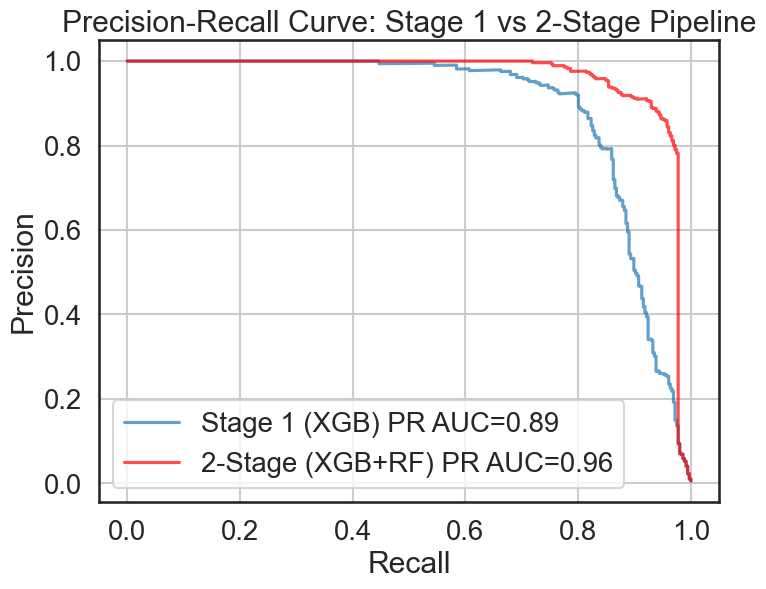

In [127]:
# Stage 1 (XGB) PR curve
precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
pr_auc1 = auc(recall1, precision1)

# Stage 2 (RF) PR curve
stage2_proba = best_rf.predict_proba(stage1_candidates_preprocessed)[:, 1]
mask_stage1 = (y_pred_stage1 == 1)

y_pred_proba_stage2 = y_pred_proba.copy()
y_pred_proba_stage2[mask_stage1] = stage2_proba

precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_pred_proba_stage2)
pr_auc2 = auc(recall2, precision2)

# plot precision-recall curves
plt.figure(figsize=(8,6))
plt.plot(recall1, precision1, label=f"Stage 1 (XGB) PR AUC={pr_auc1:.2f}", alpha=0.7)
plt.plot(recall2, precision2, label=f"2-Stage (XGB+RF) PR AUC={pr_auc2:.2f}", alpha=0.7, color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Stage 1 vs 2-Stage Pipeline")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# Summary
As we see from the confusion matrix and other metrics, this is an excellent result from our 2-stage pipeline. Out of almost 70K transactions in the test data set, only 8 fraudulent transactions were missed (recall = 0.98). While maintaining this high recall, we also optimized for precision (0.98), falsely identifying only 7 non-fraudulent transactions as fraudulent.

The initial screening (XGB) captured most of the fraudulent transactions (i.e., high recall) and further gains in fraud detection did not occur with Stage 2 (RF). However, Stage 1 also labeled almost 3K+ transactions as fraudulent when they were in fact not (precision = 0.11). This was clearly not acceptable, as it translates to annoying messages to customers or unnecessarily blocked transactions. Would you want to use a card like that? Accordingly, Stage 2 utilized a custom scorer to set a high floor for recall (at least 0.9) while optimizing for precision. The Stage 2 RF model was trained on the original training data set, but applied only to the positives identified from the first screening.

**Two Stage Pipeline Confusion Matrix (Stage 1 -> Stage 2)**

|                 | Predicted: Not Fraud | Predicted: Fraud |
|-----------------|-----------------------|------------------|
| **Actual: Not Fraud** | 64706 → 67559        | 2860 → 7         |
| **Actual: Fraud**     | 8 → 8                | 348 → 348        |


My thoughts about developing a 2-stage model were informed by my experience thinking about problems like these in the medical contexts. The present 2-stage (XGB->RF) model pipeline maximizes recall and has high precision. These outputs translate to higher customer satisfaction and cost savings for a theoretical bank. Although I am not privy to this information, I suspect that large financial institutions use some version of these types of processes for fraud detection.  

## A Note on Metrics
This is an example of rare/imbalanced class data. These are everywhere in finance, healthcare, politics, and other fields. In other words, often times the item of interest is hidden underneath a sea of noise. Accuracy as a metric, completely fails in these cases because you can get high acuracy just by predicting that everything is non-fraudulent (99.5% of the time you would be correct with the current dataset). Note that the Stage 1 model alone also had very high accuracy, but would be close to worthless in a real business context. Thus, optimizing for recall (or maybe F2 score) in Stage 1, and then optimizing for precision within a certain recall threshold (my approach) or optimizing for F1 (another potential approach not used here) for Stage 2, makes the most sense.

## A Note on Medical Screenings and Fraud
This screening structure is akin to medical contexts in that the first pass screenings are usually optimized for recall, while secondary screenings have higher precision (usually without substantial loss of recall). In effectively all contexts, these secondary screenings are more expensive (or time-consuming, which translates to an expense in itself). In the context of medicine, a high PSA (prostate-specific antigen) level may warrant a biopsy, a more costly procedure. 

In the context of fraud or anomaly detection, improper identification of fraud is extremely annoying from an end-user perspective. Wouldn't we all rather have credit cards that work perfectly at all times and alert us to fraud/perform corrective action in a perfect manner? The production ready 2-stage rare class detection pipeline presented herein might be the answer. 